In [1]:
# Import the necessary libraries
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tensorflow.keras.models import Model
from tensorflow.keras.optimizers import Adam
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras.callbacks import EarlyStopping
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_absolute_percentage_error, mean_squared_log_error
from tensorflow.keras.layers import Dense, Flatten, Conv1D, MaxPooling1D, GlobalMaxPooling1D, Dropout, SpatialDropout1D
from tensorflow.keras.layers import Layer, RepeatVector, concatenate, Reshape, Input, Concatenate, Permute, Multiply, Add, Activation

In [2]:
# Load data
df = pd.read_csv('INTC.csv')
df

,Date,Open,High,Low,Close,Adj Close,Volume
0,2019-01-02,45.959999,47.470001,45.770000,47.080002,41.513241,18774600
1,2019-01-03,46.150002,46.279999,44.389999,44.490002,39.229465,32267300
2,2019-01-04,45.840000,47.570000,45.540001,47.220001,41.636677,35447300
3,2019-01-07,47.099998,48.000000,46.750000,47.439999,41.830650,22736800
4,2019-01-08,47.799999,48.029999,46.779999,47.740002,42.095181,22749200
...,...,...,...,...,...,...,...
1079,2023-04-17,31.950001,32.639999,31.770000,32.139999,32.139999,29601100
1080,2023-04-18,32.430000,32.459999,31.780001,31.830000,31.830000,26041400
1081,2023-04-19,31.100000,31.520000,31.080000,31.150000,31.150000,25746600
1082,2023-04-20,30.760000,31.250000,30.709999,30.860001,30.860001,30255100


In [3]:
# Convert the 'Date' column to datetime format
df['Date'] = pd.to_datetime(df['Date'])

# Set the 'Date' column as the index value
df.set_index('Date', inplace=True)

In [4]:
# Show DataFrame
df

,Open,High,Low,Close,Adj Close,Volume
Date,,,,,,
2019-01-02,45.959999,47.470001,45.770000,47.080002,41.513241,18774600
2019-01-03,46.150002,46.279999,44.389999,44.490002,39.229465,32267300
2019-01-04,45.840000,47.570000,45.540001,47.220001,41.636677,35447300
2019-01-07,47.099998,48.000000,46.750000,47.439999,41.830650,22736800
2019-01-08,47.799999,48.029999,46.779999,47.740002,42.095181,22749200
...,...,...,...,...,...,...
2023-04-17,31.950001,32.639999,31.770000,32.139999,32.139999,29601100
2023-04-18,32.430000,32.459999,31.780001,31.830000,31.830000,26041400
2023-04-19,31.100000,31.520000,31.080000,31.150000,31.150000,25746600


In [5]:
# Descriptive Statistical
df.describe()

,Open,High,Low,Close,Adj Close,Volume
count,1084.000000,1084.000000,1084.000000,1084.000000,1084.000000,1.084000e+03
mean,48.699363,49.310415,48.104982,48.709797,45.224860,3.131073e+07
std,10.536348,10.628043,10.439233,10.536673,9.059149,1.619271e+07
min,24.730000,25.120001,24.590000,24.900000,24.408895,6.313200e+06
25%,45.177499,45.745000,44.549999,45.020000,41.560767,2.053605e+07
50%,50.524999,51.195000,49.990000,50.610001,46.553512,2.807305e+07
75%,56.345000,56.719999,55.709999,56.082501,51.975154,3.713008e+07
max,68.199997,69.290001,67.309998,68.470001,63.608192,1.822699e+08


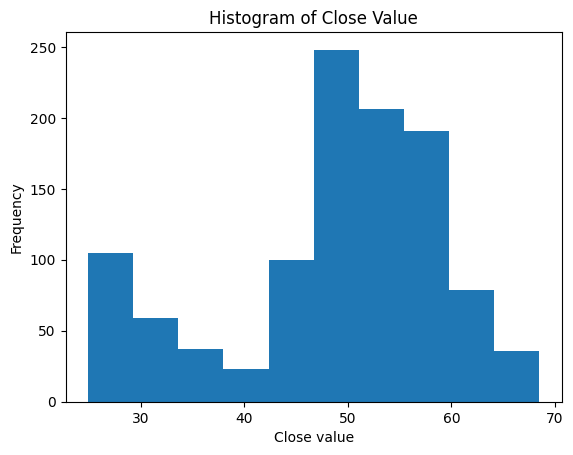

In [6]:
#  Draw a histogram
plt.hist(df['Close'])

# Set label and title
plt.xlabel('Close value')
plt.ylabel('Frequency')
plt.title('Histogram of Close Value')

# Display histogram
plt.show()

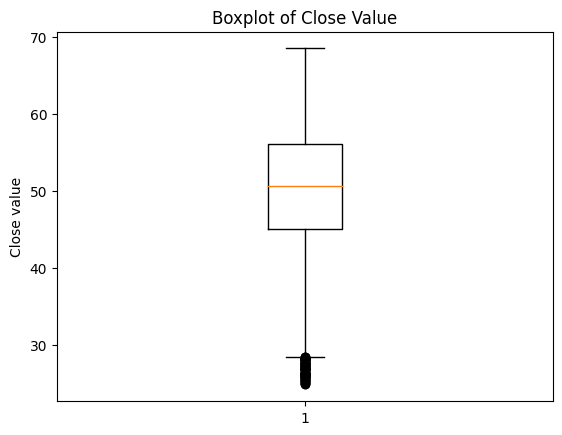

In [7]:
# Draw a boxplot
plt.boxplot(df.Close)

# Set label and title
plt.title("Boxplot of Close Value")
plt.ylabel("Close value")

# Hiển thị biểu đồ
plt.show()

In [8]:
# Select column 'Close'
data = df['Close'].values

In [9]:
# Standardized data
scaler = MinMaxScaler()
data_scaled = scaler.fit_transform(data.reshape(-1, 1))

In [10]:
# Split the data into train, validate, and test sets in a ratio of 7:2:1
train_size = int(len(data_scaled) * 0.7)
val_size = int(len(data_scaled) * 0.2)
test_size = len(data_scaled) - train_size - val_size

train_data = data_scaled[0 : train_size, :]
val_data = data_scaled[train_size : train_size + val_size, :]
test_data = data_scaled[train_size + val_size : len(data_scaled), :]

In [11]:
# Create sequences
def prepare_sequences(data, sequence_length):
    sequences, targets = [], []
    for i in range(len(data) - sequence_length - 1):
        sequences.append(data[i : (i + sequence_length), :])
        targets.append(data[i + sequence_length, 0])
    return np.array(sequences), np.array(targets)

In [12]:
sequence_length = 30
train_sequences, train_targets = prepare_sequences(train_data, sequence_length)
test_sequences, test_targets = prepare_sequences(test_data, sequence_length)
val_sequences, val_targets = prepare_sequences(val_data, sequence_length)

In [13]:
class AttentionLayer(Layer):
    def __init__(self, attention_dim):
        super(AttentionLayer, self).__init__()
        self.attention_dim = attention_dim

    def build(self, input_shape):
        self.W1 = Dense(units=self.attention_dim, activation='tanh')
        self.W2 = Dense(units=1, activation='linear')
        super(AttentionLayer, self).build(input_shape)

    def call(self, x):
        score = self.W2(self.W1(x))
        score = Flatten()(score)
        score = Activation('softmax')(score)
        score = RepeatVector(x.shape[-1])(score)
        score = Permute([2, 1])(score)
        return Multiply()([x, score])

    def compute_output_shape(self, input_shape):
        return input_shape

In [14]:
# Build TCAN model
def build_tcan(sequence_length, input_dim=1, tcn_filters=64, tcn_kernel_size=2, dropout_rate=0.2, attention_dim=16):
    inputs = Input(shape=(sequence_length, input_dim))
    x = inputs
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)
    x = Conv1D(filters=tcn_filters, kernel_size=tcn_kernel_size, padding='same', activation='relu')(x)
    x = SpatialDropout1D(rate=dropout_rate)(x)

    # Additive Attention
    att = AttentionLayer(attention_dim)(x)
    max_pool_att = GlobalMaxPooling1D()(att)
    max_pool_x = GlobalMaxPooling1D()(x)
    x = concatenate([max_pool_att, max_pool_x])

    outputs = Dense(1)(x)

    model = Model(inputs=inputs, outputs=outputs)
    optimizer = Adam(learning_rate=0.001)
    model.compile(loss='mean_absolute_error', optimizer=optimizer)

    return model

In [15]:
# Model building
model = build_tcan(sequence_length)
early_stop = EarlyStopping(monitor='val_loss', patience=5)
# Model training
history = model.fit(train_sequences, train_targets, epochs=50, batch_size=32, validation_data=(val_sequences, val_targets), 
                    shuffle=False, callbacks=[early_stop], verbose=1)

Epoch 1/50
23/23 [==============================] - 7s 53ms/step - loss: 0.3219 - val_loss: 0.1836
Epoch 2/50
23/23 [==============================] - 1s 23ms/step - loss: 0.1174 - val_loss: 0.0814
Epoch 3/50
23/23 [==============================] - 1s 32ms/step - loss: 0.0943 - val_loss: 0.0807
Epoch 4/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0882 - val_loss: 0.0952
Epoch 5/50
23/23 [==============================] - 1s 29ms/step - loss: 0.0867 - val_loss: 0.0798
Epoch 6/50
23/23 [==============================] - 1s 26ms/step - loss: 0.0779 - val_loss: 0.0848
Epoch 7/50
23/23 [==============================] - 1s 25ms/step - loss: 0.0811 - val_loss: 0.0696
Epoch 8/50
23/23 [==============================] - 1s 31ms/step - loss: 0.0764 - val_loss: 0.0638
Epoch 9/50
23/23 [==============================] - 1s 27ms/step - loss: 0.0719 - val_loss: 0.0667
Epoch 10/50
23/23 [==============================] - 1s 23ms/step - loss: 0.0692 - val_loss: 0.0603
Epoch 11/

In [16]:
# Prediction on test set
y_pred = model.predict(test_sequences)

3/3 [==============================] - 1s 13ms/step


In [17]:
# Evaluate the accuracy of test
test_mae = mean_absolute_error(test_targets, y_pred)
test_mape = mean_absolute_percentage_error(test_targets, y_pred)
test_mse = mean_squared_error(test_targets, y_pred)
test_rmse = np.sqrt(test_mse)
test_msle = mean_squared_log_error(test_targets, y_pred)

print(f"MAE on Test set: ", test_mae)
print(f"MAPE on Test set: ", test_mape)
print(f"MSE on Test set: ", test_mse)
print(f"RMSE on Test set: ", test_rmse)
print(f"MSLE on Test set: ", test_msle)

MAE on Test set:  0.11547758908590439
MAPE on Test set:  11016836613761.504
MSE on Test set:  0.014829496005075266
RMSE on Test set:  0.12177641809921684
MSLE on Test set:  0.01167438192719372


In [18]:
# Get the last date from the current index
last_date = df.index[-1]

# Add one day to the last date
next_date = last_date + pd.DateOffset(days=1)

# Create a list of indices starting from the next date for 30 days
index_next_30_days = pd.date_range(start=next_date, periods=30).tolist()

# Predict the closing price for the next 30 days
last_sequence_days = data[-sequence_length:].reshape(1, -1, 1)
y_next_30_days = []

for i in range(30):
    # Predict the next day's closing price
    next_day_pred = model.predict(last_sequence_days)
    
    # Save prediction
    y_next_30_days.append(next_day_pred[0][0])
    
    # Update data for the next day
    last_sequence_days = np.concatenate([last_sequence_days[:, 1:, :], next_day_pred.reshape(1, 1, 1)], axis=1)

1/1 [==============================] - 0s 32ms/step


In [19]:
len(scaler.inverse_transform(val_data))

216

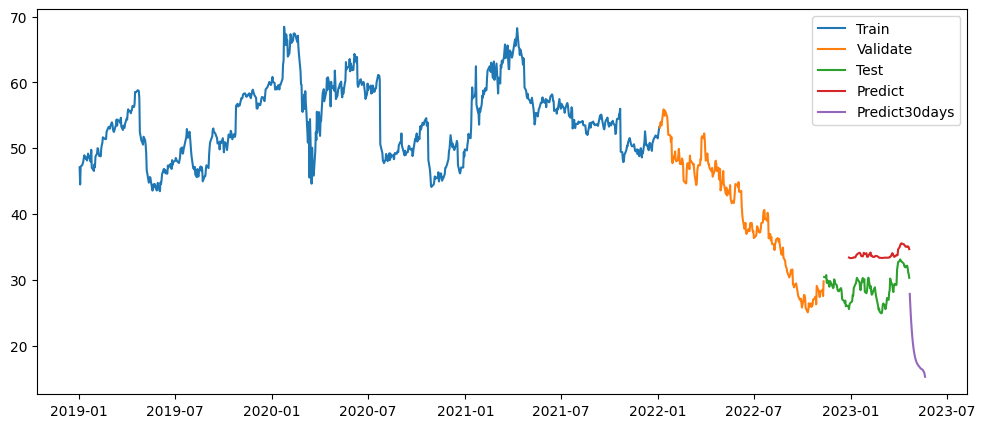

In [20]:
# Visualization
plt.figure(figsize=(12, 5))

plt.plot(df.index[:train_size], scaler.inverse_transform(train_data))

plt.plot(df.index[train_size : train_size + val_size], scaler.inverse_transform(val_data))

plt.plot(df.index[train_size + val_size : ], scaler.inverse_transform(test_data))

plt.plot(df.index[train_size + val_size + sequence_length + 1: ],scaler.inverse_transform(y_pred))

plt.plot(index_next_30_days, y_next_30_days)

plt.legend(['Train', 'Validate', 'Test', 'Predict', 'Predict30days'])
plt.show()